## Importing the modules

In [23]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import *

np.random.seed(1)

## Loading dataset

In [24]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

## Visualize our dataset

y = 5


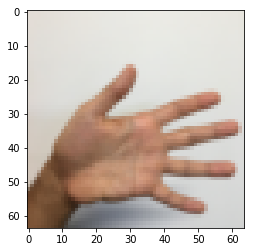

In [25]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

## One hot encoding

In [26]:
def convert_one_hot(labels, C):
    C = tf.constant(C, name = "C")
    
    one_hot_matrix = tf.one_hot(indices = labels, depth = C, axis = 0)
    
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    
    return one_hot

## Process data

In [27]:
# Flatten the data
X_train = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test = X_test_orig.reshape(X_test_orig.shape[0], -1).T

#Normalize
X_train = X_train / 255
X_test = X_test / 255

#One-hot encoding
Y_train = convert_one_hot(Y_train_orig, 6).reshape(6,1080)
Y_test = convert_one_hot(Y_test_orig, 6).reshape(6,120)

print("Number of training examples = ", X_train.shape[1])
print("Number of testing examples = ", X_test.shape[1])
print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)
print("Y_train shape = ", Y_train.shape)
print("Y_test shape = ", Y_test.shape)
#print(Y_train)
#print(Y_test)


Number of training examples =  1080
Number of testing examples =  120
X_train shape =  (12288, 1080)
X_test shape =  (12288, 120)
Y_train shape =  (6, 1080)
Y_test shape =  (6, 120)


## Create placeholder

In [28]:
def create_placeholder(n_x, n_y):
    X = tf.placeholder(tf.float32, shape = [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [n_y, None], name = "Y")    
    
    return X, Y

## Init parameter

In [29]:
def init_parameter():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [30, 12288], initializer= tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [30, 1], initializer= tf.zeros_initializer())
    W2 = tf.get_variable("W2", [20, 30], initializer= tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [20, 1], initializer= tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 20], initializer= tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [6, 1], initializer= tf.zeros_initializer())
    
    parameter = {"W1": W1,
                 "b1": b1,
                 "W2": W2,
                 "b2": b2,
                 "W3": W3,
                 "b3": b3}
    
    return parameter

## Forward prop

In [30]:
def forward_prop(X, parameter):
    
    W1 = parameter["W1"]
    b1 = parameter["b1"]
    W2 = parameter["W2"]
    b2 = parameter["b2"]
    W3 = parameter["W3"]
    b3 = parameter["b3"]
    
    Z1 = tf.matmul(W1, X) + b1
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(W2, A1) + b2
    A2 = tf.nn.relu(Z2)
    Z3 = tf.matmul(W3, A2) + b3
    
    return Z3

## Compute cost

In [31]:
def compute_cost(Z3, Y):
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels= labels))
    
    return cost

## Building the model

In [32]:
def model(X_train, Y_train, learning_rate = 0.0001, num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    #create placeholder
    X, Y = create_placeholder(n_x, n_y)
    
    #initialize parameter
    parameters = init_parameter()
    
    #forward prop
    Z3 = forward_prop(X, parameters)
    
    #compute cost
    cost = compute_cost(Z3, Y)
    
    #Backward propagation
    #Tensorflow optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(cost)
    
    #Initialize variables
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0
            
            num_minibatch = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                
                (minibatch_X, minibatch_Y) = minibatch
                
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatch
        
        # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        
        parameters = sess.run(parameters)
        
        
        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        
        return parameters

Cost after epoch 0: 1.874547
Cost after epoch 100: 0.836841
Cost after epoch 200: 0.604687
Cost after epoch 300: 0.458274
Cost after epoch 400: 0.356445
Cost after epoch 500: 0.269410
Cost after epoch 600: 0.196516
Cost after epoch 700: 0.128013
Cost after epoch 800: 0.081483
Cost after epoch 900: 0.049324
Cost after epoch 1000: 0.031773
Cost after epoch 1100: 0.016223
Cost after epoch 1200: 0.009325
Cost after epoch 1300: 0.005502
Cost after epoch 1400: 0.004278


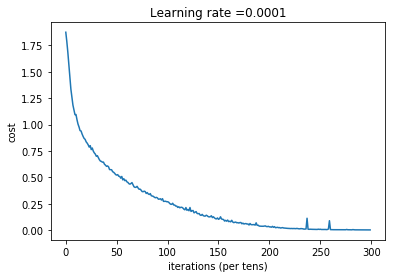

Train Accuracy: 1.0
Test Accuracy: 0.80833334


In [33]:
parmeters = model(X_train, Y_train)

## Testing it with your data

/home/anon/.conda/envs/darklord/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/anon/.conda/envs/darklord/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


Your algorithm predicts: y = 1


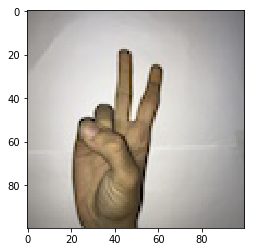

In [38]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "two1.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parmeters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))